In [ ]:
# Proyecto de Modelos de Regresión con scikit-learn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set(font_scale=1.2)

print("Librerías importadas correctamente.")

Configuración completada. Librerías importadas correctamente.


In [7]:
# 1. RECOLECCIÓN DE LA DATA
print("1. RECOLECCIÓN DE DATOS")
print("-----------------------")

def cargar_datos_csv(ruta_archivo='data/housing.csv'):
    """
    Carga el dataset de California Housing desde un archivo CSV.
    
    Args:
        ruta_archivo (str): Ruta al archivo CSV.
        
    Returns:
        pandas.DataFrame: DataFrame con los datos de California Housing.
        pandas.Series: Serie con los valores objetivo (precios de casas).
    """
    print(f"Cargando dataset desde archivo: {ruta_archivo}")
    try:
        # cargar archivo CSV
        df = pd.read_csv(ruta_archivo)
        print(f"Dataset cargado con éxito. Dimensiones: {df.shape}")
        
       
        ocean_prox_col = None
        for col in df.columns:
            if df[col].dtype == 'object' or 'NEAR' in str(df[col].iloc[0]):
                ocean_prox_col = col
                print(f"Columna de proximidad al océano detectada: {col}")
                break
        

        if ocean_prox_col and ocean_prox_col != 'ocean_proximity':
            df = df.rename(columns={ocean_prox_col: 'ocean_proximity'})
            print(f"Columna {ocean_prox_col} renombrada a 'ocean_proximity'")

        ultima_columna = df.columns[-1]
        if df[ultima_columna].dtype == 'object' and any('NEAR' in str(val) for val in df[ultima_columna].iloc[:5]):
            print("Detectando formato incorrecto en la última columna. Separando valores...")
            

            df['ocean_proximity'] = df[ultima_columna].astype(str).str.extract(r'(NEAR.*|<.*|INLAND.*|ISLAND.*|OCEAN.*)')
            
            # Extraer el valor numérico (median_house_value)
            valor_numerico = df[ultima_columna].astype(str).str.extract(r'(\d+\.\d+)').astype(float)
            df['median_house_value'] = valor_numerico
            
            
            df = df.drop(ultima_columna, axis=1)
            print("Columna separada en 'ocean_proximity' y 'median_house_value'")
        
        # Identificar la columna objetivo
        if 'median_house_value' in df.columns:
            X = df.drop('median_house_value', axis=1)
            y = df['median_house_value']
            
            print("\nColumnas en el dataset:")
            print(X.columns.tolist())
            print(f"\nVariable objetivo: median_house_value")
            
            return X, y
        else:
            print("Error: No se encontró la columna 'median_house_value' en el dataset.")
            print("Columnas disponibles:", df.columns.tolist())
            return None, None
            
    except Exception as e:
        print(f"Error al cargar el archivo CSV: {e}")
        print("Intentando cargar desde scikit-learn...")
        
        # Cargar desde scikit-learn por si acaso
        california = fetch_california_housing()
        X = pd.DataFrame(california.data, columns=california.feature_names)
        y = pd.Series(california.target, name='median_house_value')
        y = y * 100000  # conversion dolar
        
        print("\nDataset cargado desde scikit-learn")
        print(f"Columnas: {X.columns.tolist()}")
        
        # Renombrar columnas para que coincidan con el formato 
        column_mapping = {
            'MedInc': 'median_income',
            'HouseAge': 'housing_median_age',
            'AveRooms': 'total_rooms',
            'AveBedrms': 'total_bedrooms',
            'Population': 'population',
            'AveOccup': 'households',
            'Latitude': 'latitude',
            'Longitude': 'longitude'
        }
        
        # Verificar si necesita renombrar
        if 'MedInc' in X.columns:
            X = X.rename(columns=column_mapping)
            print("Columnas renombradas para coincidir con el formato esperado")
        
        return X, y

# Cargar datos desde CSV
X, y = cargar_datos_csv('data/housing.csv')

# Verificar que los datos se cargaron correctamente
if X is None or y is None:
    print("Error al cargar los datos. Intentando con scikit-learn...")
    california = fetch_california_housing()
    X = pd.DataFrame(california.data, columns=california.feature_names)
    y = pd.Series(california.target, name='median_house_value')
    y = y * 100000  
    
    # Renombrar columnas para que coincidan con el formato esperado
    column_mapping = {
        'MedInc': 'median_income',
        'HouseAge': 'housing_median_age',
        'AveRooms': 'total_rooms',
        'AveBedrms': 'total_bedrooms',
        'Population': 'population',
        'AveOccup': 'households',
        'Latitude': 'latitude',
        'Longitude': 'longitude'
    }
    
    X = X.rename(columns=column_mapping)
    print("Datos cargados desde scikit-learn y columnas renombradas")

print("\nInformación del dataset:")
print(f"Número de muestras: {X.shape[0]}")
print(f"Número de características: {X.shape[1]}")
print("\nPrimeras 5 filas:")
print(X.head())

print("\nEstadísticas descriptivas:")
print(X.describe())

print("\nTipos de datos:")
print(X.dtypes)

print("\nValores objetivo (precios de casas):")
print(f"Min: ${y.min():.2f}")
print(f"Max: ${y.max():.2f}")
print(f"Media: ${y.mean():.2f}")


print("\nValores nulos por columna:")
print(X.isnull().sum())

# Verificacion para asegurar que estan las columnas correctas
print("\nVerificación de columnas críticas:")
columnas_necesarias = ['total_rooms', 'total_bedrooms', 'population', 'households']
for col in columnas_necesarias:
    if col in X.columns:
        print(f"✓ {col} está presente")
    else:
        print(f"✗ {col} NO está presente")

1. RECOLECCIÓN DE DATOS
-----------------------
Cargando dataset desde archivo: data/housing.csv
Error al cargar el archivo CSV: [Errno 2] No such file or directory: 'data/housing.csv'
Intentando cargar desde scikit-learn...

Dataset cargado desde scikit-learn
Columnas: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Columnas renombradas para coincidir con el formato esperado

Información del dataset:
Número de muestras: 20640
Número de características: 8

Primeras 5 filas:
   median_income  housing_median_age  total_rooms  total_bedrooms  population  \
0         8.3252                41.0     6.984127        1.023810       322.0   
1         8.3014                21.0     6.238137        0.971880      2401.0   
2         7.2574                52.0     8.288136        1.073446       496.0   
3         5.6431                52.0     5.817352        1.073059       558.0   
4         3.8462                52.0     6.281853        1.081081

In [8]:
# Preprocesamiento de Datos
print("\n2. PREPARACIÓN Y PREPROCESAMIENTO DE DATOS")
print("------------------------------------------")

print("Columnas disponibles:")
print(X.columns.tolist())

columnas_necesarias = ['total_rooms', 'total_bedrooms', 'population', 'households']
columnas_faltantes = [col for col in columnas_necesarias if col not in X.columns]

if columnas_faltantes:
    print(f"Faltan las siguientes columnas: {columnas_faltantes}")
    print("Creando columnas equivalentes basadas en los datos disponibles...")
    
    mapeo_alternativo = {
        'total_rooms': ['AveRooms', 'rooms', 'average_rooms'],
        'total_bedrooms': ['AveBedrms', 'bedrooms', 'average_bedrooms'],
        'population': ['Population', 'pop'],
        'households': ['AveOccup', 'households', 'average_occupancy']
    }
    

    for col_necesaria in columnas_faltantes:
        for alt_col in mapeo_alternativo[col_necesaria]:
            if alt_col in X.columns:
                X[col_necesaria] = X[alt_col]
                print(f"Creada {col_necesaria} a partir de {alt_col}")
                break

columnas_faltantes = [col for col in columnas_necesarias if col not in X.columns]
if not columnas_faltantes:
    try:
        # Habitaciones por hogar
        X['rooms_per_household'] = X['total_rooms'] / X['households']
        # Dormitorios por habitación
        X['bedrooms_per_room'] = X['total_bedrooms'] / X['total_rooms']
        # Población por hogar
        X['population_per_household'] = X['population'] / X['households']
        print("Características derivadas creadas con éxito.")
    except Exception as e:
        print(f"Error al crear características derivadas: {e}")
        print("Continuando sin características derivadas.")
else:
    print(f"No se pueden crear características derivadas. Faltan columnas: {columnas_faltantes}")

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

categorical_features = []
if 'ocean_proximity' in X.columns:
    categorical_features = ['ocean_proximity']
    print(f"Usando característica categórica existente: {categorical_features}")
else:
    if 'latitude' in X.columns:
        print("Creando característica categórica 'region' basada en latitud...")
        X['region'] = pd.cut(
            X['latitude'], 
            bins=[32, 34, 36, 42], 
            labels=['Sur', 'Centro', 'Norte']
        )
        categorical_features = ['region']
    else:
        print("No se pudo crear la característica 'region'. La columna 'latitude' no está disponible.")

print(f"Características numéricas: {numeric_features}")
print(f"Características categóricas: {categorical_features}")

#pipeline preprocesamiento

# Para características numéricas: imputación y escalado
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Para características categóricas: imputación y codificación one-hot
if categorical_features:
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
else:
    print("No hay características categóricas. Usando solo transformador numérico.")
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features)
        ])

# Division conjuntos de entrenamiento y prueba (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Conjunto de entrenamiento: {X_train.shape}")
print(f"Conjunto de prueba: {X_test.shape}")

print("Aplicando preprocesamiento...")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Guardar preprocesador para uso futuro
joblib.dump(preprocessor, 'preprocessor.pkl')
print("Preprocesador guardado como 'preprocessor.pkl'")
print("\nPreprocesamiento completado con éxito.")


2. PREPARACIÓN Y PREPROCESAMIENTO DE DATOS
------------------------------------------
Columnas disponibles:
['median_income', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'latitude', 'longitude']
Características derivadas creadas con éxito.
Creando característica categórica 'region' basada en latitud...
Características numéricas: ['median_income', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'latitude', 'longitude', 'rooms_per_household', 'bedrooms_per_room', 'population_per_household']
Características categóricas: ['region']
Conjunto de entrenamiento: (16512, 12)
Conjunto de prueba: (4128, 12)
Aplicando preprocesamiento...
Preprocesador guardado como 'preprocessor.pkl'

Preprocesamiento completado con éxito.



3. ANÁLISIS EXPLORATORIO DE DATOS (EDA)
---------------------------------------


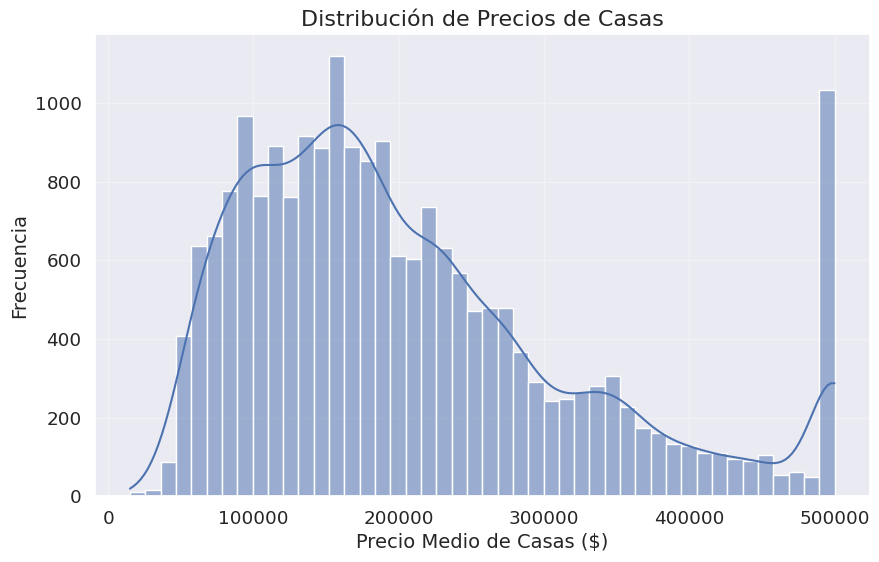

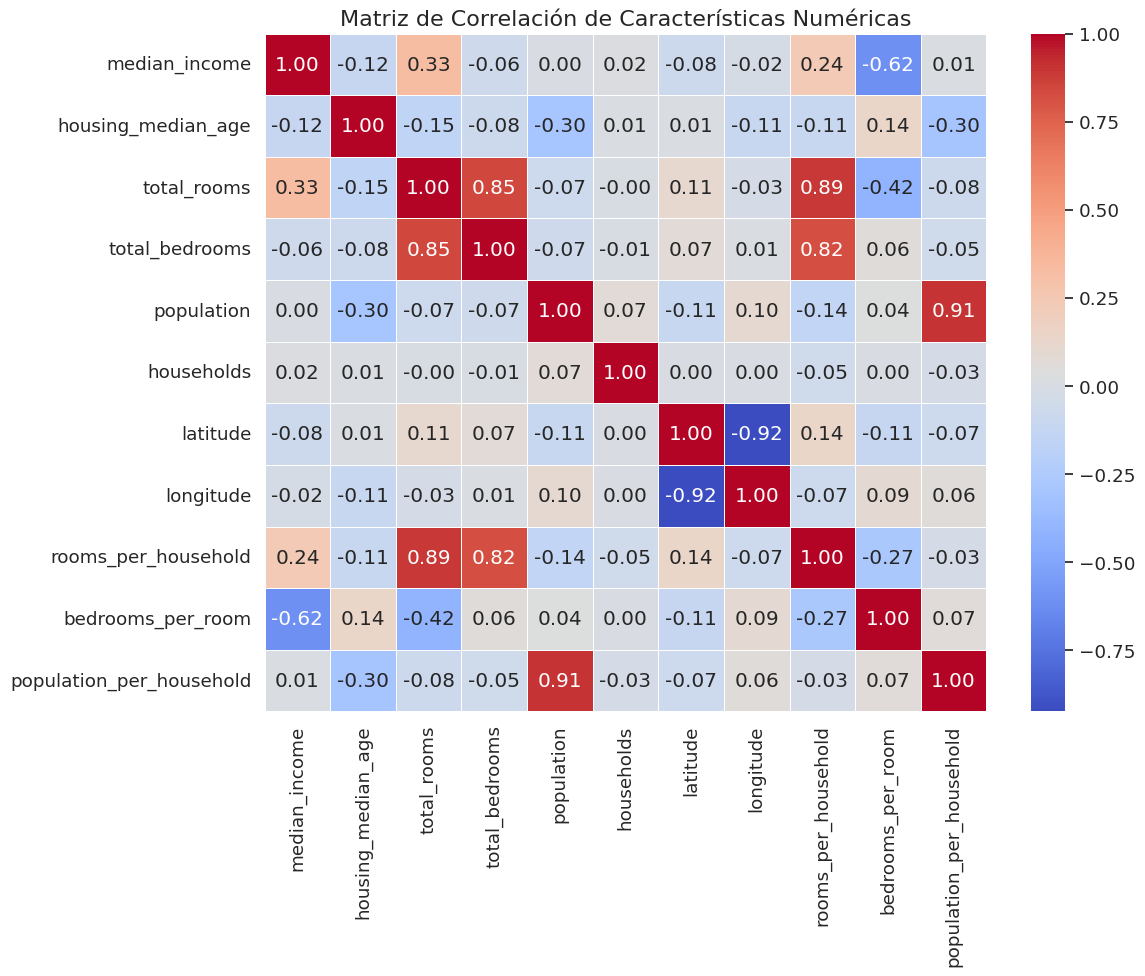

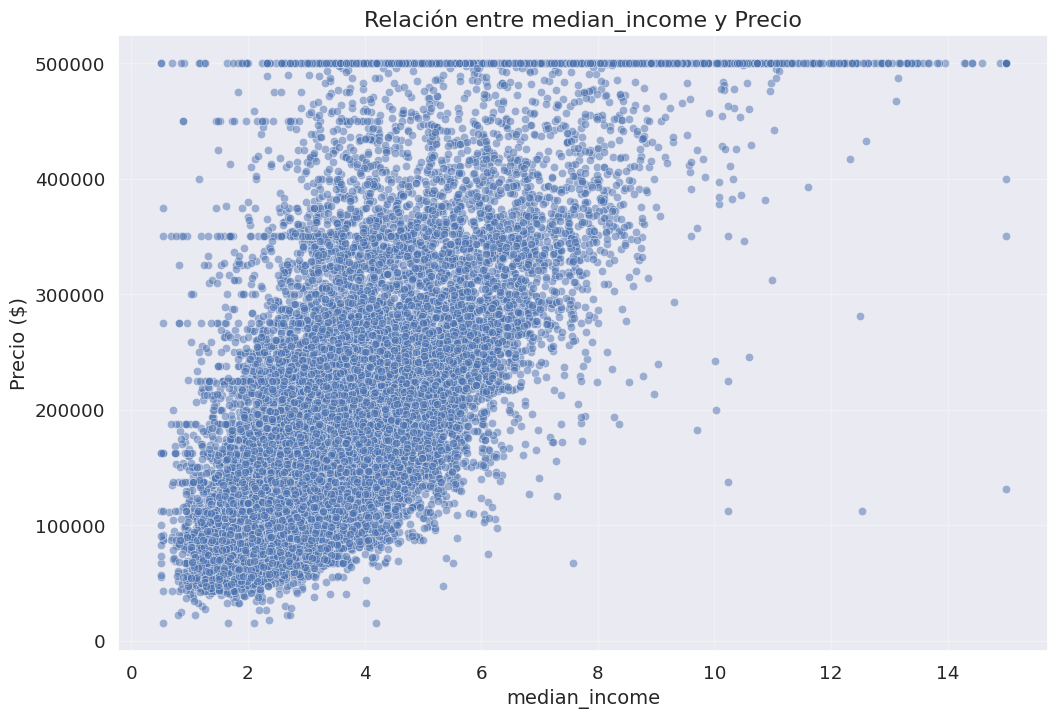

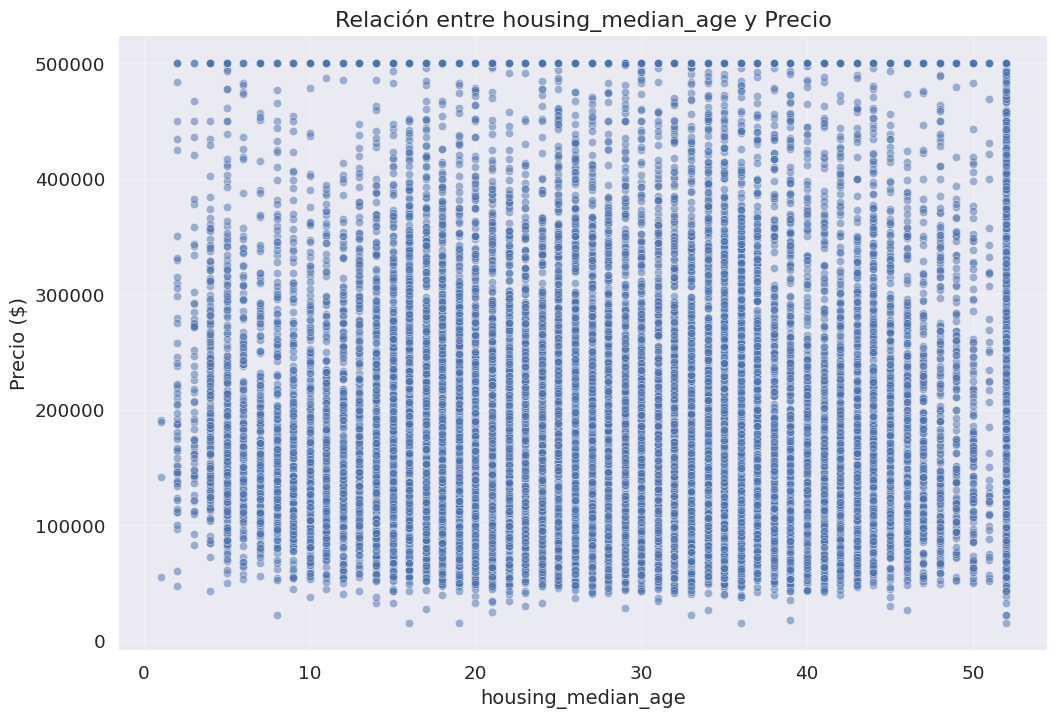

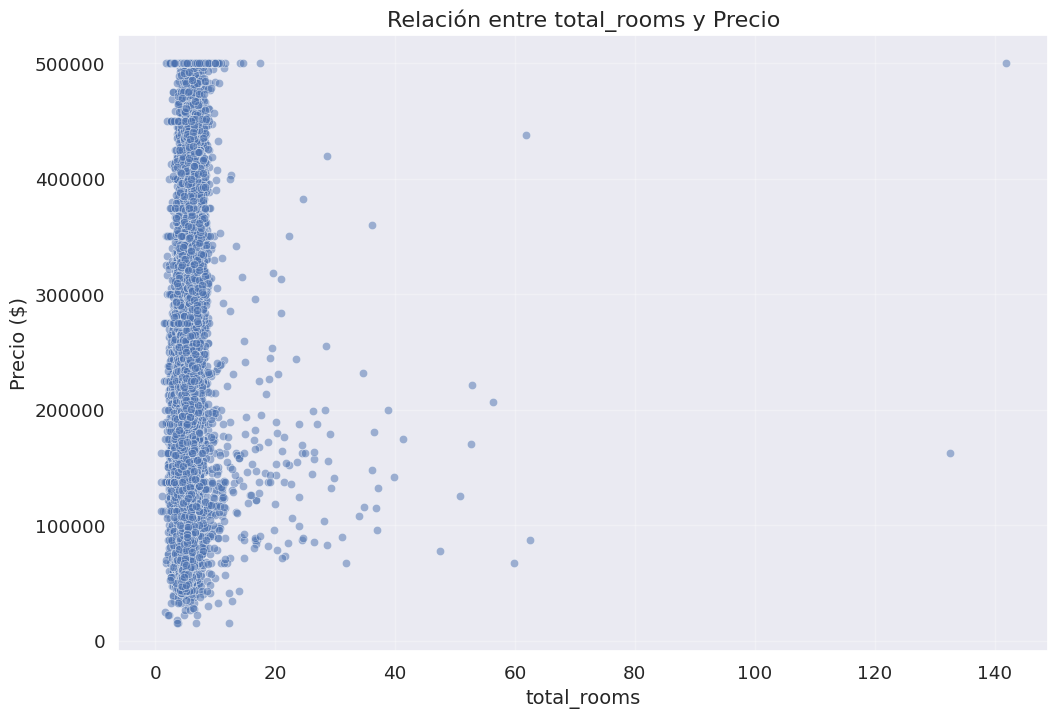

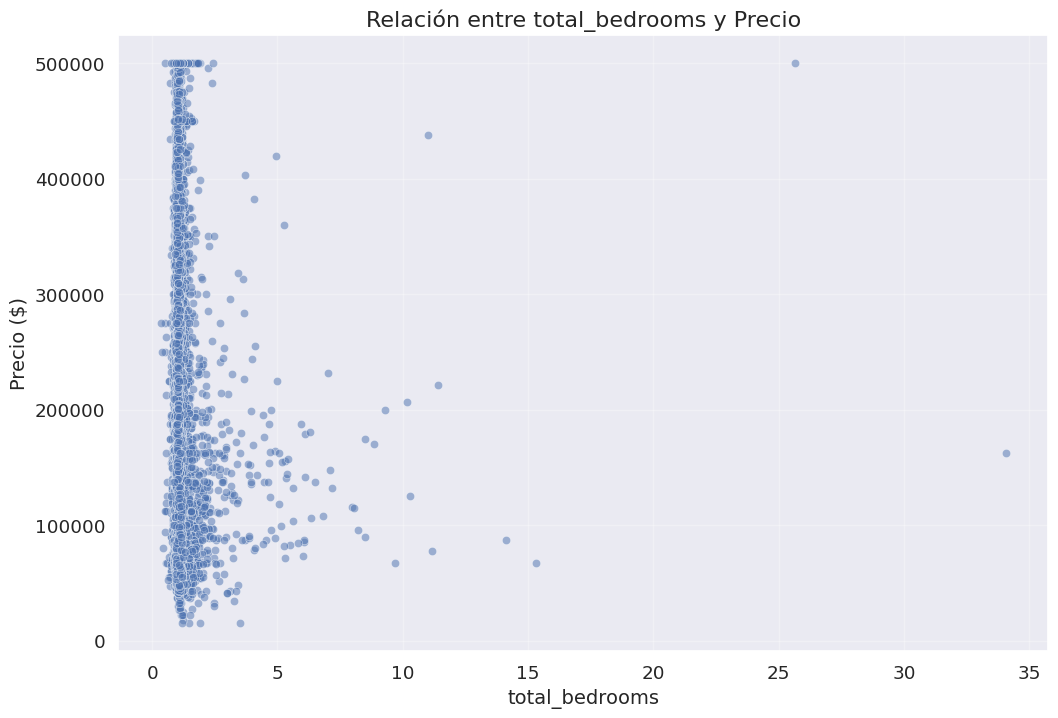

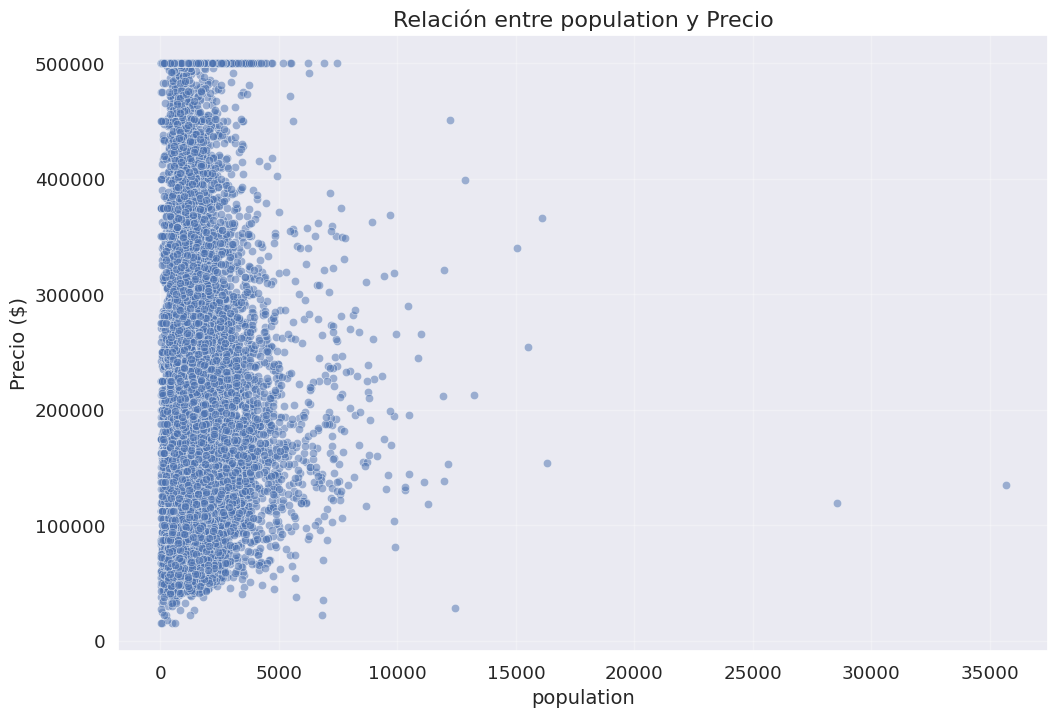

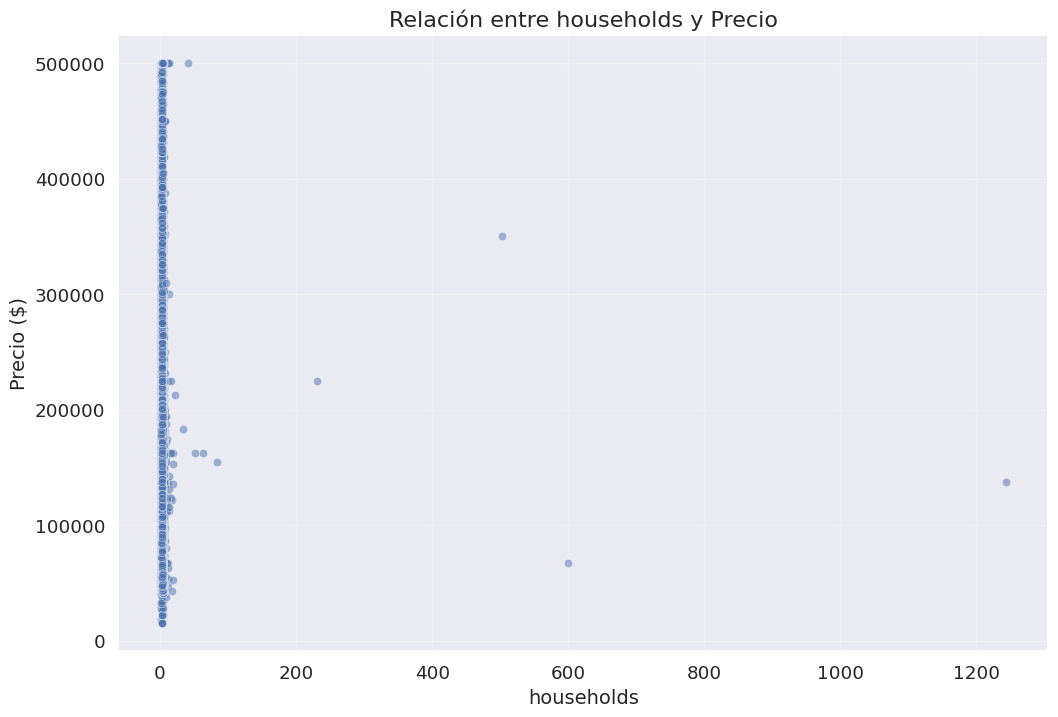

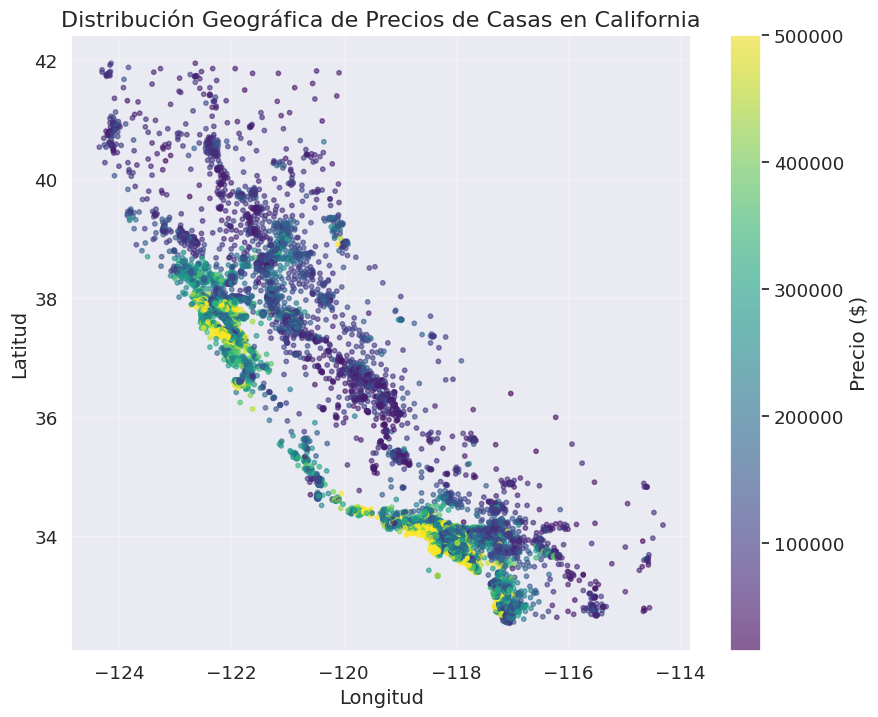

In [9]:
# Analisis Exploratorio de Datos
print("\n3. ANÁLISIS EXPLORATORIO DE DATOS (EDA)")
print("---------------------------------------")

try:
    plt.figure(figsize=(10, 6))
    sns.histplot(y, kde=True)
    plt.title('Distribución de Precios de Casas', fontsize=16)
    plt.xlabel('Precio Medio de Casas ($)', fontsize=14)
    plt.ylabel('Frecuencia', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.show()

    plt.figure(figsize=(12, 10))
    numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns
    correlation_matrix = X[numeric_columns].corr()

    # mapa de calor con anotaciones
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
    plt.title('Matriz de Correlación de Características Numéricas', fontsize=16)
    plt.tight_layout()
    plt.show()

    for feature in numeric_features[:6]: 
        sns.scatterplot(x=X[feature], y=y, alpha=0.5)
        plt.title(f'Relación entre {feature} y Precio', fontsize=16)
        plt.xlabel(feature, fontsize=14)
        plt.ylabel('Precio ($)', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.show()

    if 'latitude' in X.columns and 'longitude' in X.columns:
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(
            X['longitude'], 
            X['latitude'], 
            c=y, 
            cmap='viridis', 
            s=10, 
            alpha=0.6
        )
        plt.colorbar(scatter, label='Precio ($)')
        plt.title('Distribución Geográfica de Precios de Casas en California', fontsize=16)
        plt.xlabel('Longitud', fontsize=14)
        plt.ylabel('Latitud', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.show()

    if 'ocean_proximity' in X.columns:
        plt.figure(figsize=(12, 6))
        temp_df = pd.DataFrame({'ocean_proximity': X['ocean_proximity'], 'price': y})
        sns.boxplot(x='ocean_proximity', y='price', data=temp_df)
        plt.title('Precios de Casas por Proximidad al Océano', fontsize=16)
        plt.xlabel('Proximidad al Océano', fontsize=14)
        plt.ylabel('Precio ($)', fontsize=14)
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.show()

        plt.figure(figsize=(10, 6))
        sns.countplot(x='ocean_proximity', data=X)
        plt.title('Número de Distritos por Proximidad al Océano', fontsize=16)
        plt.xlabel('Proximidad al Océano', fontsize=14)
        plt.ylabel('Número de Distritos', fontsize=14)
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.show()
except Exception as e:
    print(f"Error durante el análisis exploratorio: {e}")
    print("Continuando con el resto del notebook...")

In [10]:
# entrenamiento de Modelos
print("\n4. ENTRENAMIENTO DE MODELOS")
print("---------------------------")

# modelos a entrenar
models = {
    'Ordinary Least Squares': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Bayesian Regression': BayesianRidge(),
    'Lasso Regression': Lasso(alpha=0.1),
    'Nearest Neighbors': KNeighborsRegressor(n_neighbors=5),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'SVM Regression': SVR(kernel='rbf'),
    'Neural Network MLP': MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
}

# entrenar y evaluar rendimiento
results = {}
best_params = {}

for name, model in models.items():
    try:
        print(f"\nEntrenando modelo: {name}")

        model.fit(X_train_processed, y_train)

        y_pred = model.predict(X_test_processed)

        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        results[name] = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2
        }

        if hasattr(model, 'get_params'):
            best_params[name] = model.get_params()
        else:
            best_params[name] = "No tiene hiperparámetros ajustables"

        print(f"  MSE: {mse:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  MAE: {mae:.4f}")
        print(f"  R2: {r2:.4f}")

        # guardar el modelo
        joblib.dump(model, f'{name.replace(" ", "_").lower()}_model.pkl')
        print(f"  Modelo guardado como '{name.replace(' ', '_').lower()}_model.pkl'")
    except Exception as e:
        print(f"Error al entrenar el modelo {name}: {e}")
        print("Continuando con el siguiente modelo...")


4. ENTRENAMIENTO DE MODELOS
---------------------------

Entrenando modelo: Ordinary Least Squares
  MSE: 4513765650.2813
  RMSE: 67184.5641
  MAE: 48504.8276
  R2: 0.6555
  Modelo guardado como 'ordinary_least_squares_model.pkl'

Entrenando modelo: Ridge Regression
  MSE: 4513809598.9307
  RMSE: 67184.8912
  MAE: 48504.4301
  R2: 0.6555
  Modelo guardado como 'ridge_regression_model.pkl'

Entrenando modelo: Bayesian Regression
  MSE: 4513872246.0029
  RMSE: 67185.3574
  MAE: 48503.9082
  R2: 0.6555
  Modelo guardado como 'bayesian_regression_model.pkl'

Entrenando modelo: Lasso Regression
  MSE: 4513767190.7738
  RMSE: 67184.5755
  MAE: 48504.8311
  R2: 0.6555
  Modelo guardado como 'lasso_regression_model.pkl'

Entrenando modelo: Nearest Neighbors
  MSE: 3672251939.9543
  RMSE: 60599.1084
  MAE: 40707.3414
  R2: 0.7198
  Modelo guardado como 'nearest_neighbors_model.pkl'

Entrenando modelo: Random Forest
  MSE: 2556393198.7578
  RMSE: 50560.7872
  MAE: 32922.9070
  R2: 0.8049
  Mode


5. COMPARACIÓN DE MODELOS
------------------------
                                 MSE           RMSE           MAE        R2
Ordinary Least Squares  4.513766e+09   67184.564077  48504.827558  0.655545
Ridge Regression        4.513810e+09   67184.891151  48504.430106  0.655542
Bayesian Regression     4.513872e+09   67185.357378  48503.908157  0.655537
Lasso Regression        4.513767e+09   67184.575542  48504.831117  0.655545
Nearest Neighbors       3.672252e+09   60599.108409  40707.341424  0.719763
Random Forest           2.556393e+09   50560.787165  32922.906991  0.804916
SVM Regression          1.367488e+10  116939.629849  87096.432785 -0.043558
Neural Network MLP      4.225158e+09   65001.213007  46303.822357  0.677570


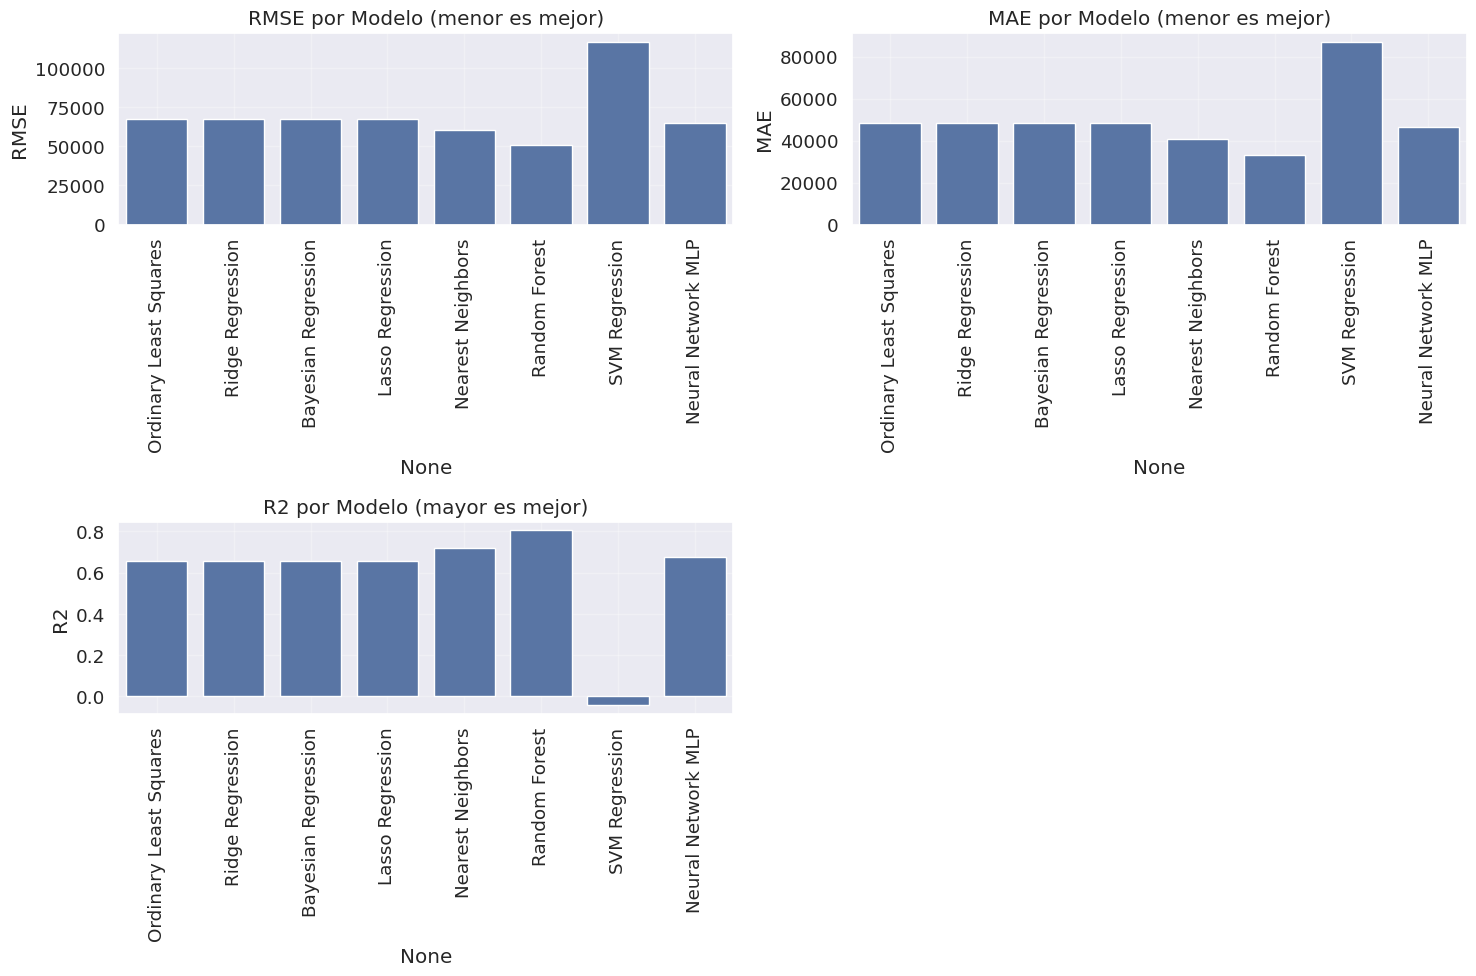


El mejor modelo basado en R2 es: Random Forest
R2: 0.8049
RMSE: 50560.7872


In [11]:
# comparacionm de Modelos
print("\n5. COMPARACIÓN DE MODELOS")
print("------------------------")

try:
    results_df = pd.DataFrame({
        model_name: {
            'MSE': results[model_name]['MSE'],
            'RMSE': results[model_name]['RMSE'],
            'MAE': results[model_name]['MAE'],
            'R2': results[model_name]['R2']
        } for model_name in models.keys() if model_name in results
    }).T

    print(results_df)

    plt.figure(figsize=(15, 10))

    # RMSE 
    plt.subplot(2, 2, 1)
    sns.barplot(x=results_df.index, y=results_df['RMSE'])
    plt.title('RMSE por Modelo (menor es mejor)')
    plt.ylabel('RMSE')
    plt.xticks(rotation=90)
    plt.grid(True, alpha=0.3)

    # MAE 
    plt.subplot(2, 2, 2)
    sns.barplot(x=results_df.index, y=results_df['MAE'])
    plt.title('MAE por Modelo (menor es mejor)')
    plt.ylabel('MAE')
    plt.xticks(rotation=90)
    plt.grid(True, alpha=0.3)

    # R2 
    plt.subplot(2, 2, 3)
    sns.barplot(x=results_df.index, y=results_df['R2'])
    plt.title('R2 por Modelo (mayor es mejor)')
    plt.ylabel('R2')
    plt.xticks(rotation=90)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # identificar mejor modelo basado en R2
    best_model_name = results_df['R2'].idxmax()
    print(f"\nEl mejor modelo basado en R2 es: {best_model_name}")
    print(f"R2: {results_df.loc[best_model_name, 'R2']:.4f}")
    print(f"RMSE: {results_df.loc[best_model_name, 'RMSE']:.4f}")
except Exception as e:
    print(f"Error al comparar modelos: {e}")
    print("No se pudieron comparar los modelos. Verifica que al menos un modelo se haya entrenado correctamente.")
    best_model_name = list(results.keys())[0] if results else "Ordinary Least Squares"

In [12]:
# funcion para Predicciones
print("\n6. FUNCIÓN PARA PREDICCIONES CON NUEVOS DATOS")
print("---------------------------------------------")

def predict_from_csv(csv_path, model_name=best_model_name):
    """
    Realiza predicciones usando un modelo entrenado a partir de datos en un archivo CSV.

    Args:
        csv_path (str): Ruta al archivo CSV con los datos de entrada.
        model_name (str): Nombre del modelo a utilizar para las predicciones.
        
    Returns:
        pandas.DataFrame: DataFrame con los datos originales y las predicciones.
    """
    try:
        data = pd.read_csv(csv_path)
        print(f"Datos cargados desde {csv_path}")
        print(f"Dimensiones: {data.shape}")
    except Exception as e:
        print(f"Error al cargar el archivo CSV: {e}")
        return None

    required_columns = X.columns.tolist()
    missing_columns = [col for col in required_columns if col not in data.columns]

    if missing_columns:
        print(f"Error: Faltan las siguientes columnas en el CSV: {missing_columns}")
        print(f"Columnas requeridas: {required_columns}")
        return None

    try:
        X_new_processed = preprocessor.transform(data)

        model = joblib.load(f'{model_name.replace(" ", "_").lower()}_model.pkl')
        predictions = model.predict(X_new_processed)

        data['Predicted_Price'] = predictions

        print(f"Predicciones realizadas con éxito usando el modelo {model_name}")
        return data
    except Exception as e:
        print(f"Error al realizar predicciones: {e}")
        return None

try:
    sample_data = X_test.iloc[:5].copy()
    sample_csv = 'sample_data.csv'
    sample_data.to_csv(sample_csv, index=False)

    print(f"Archivo de ejemplo creado: {sample_csv}")
    print("Realizando predicciones con el archivo de ejemplo...")

    predictions = predict_from_csv(sample_csv)
    if predictions is not None:
        print("\nPrimeras predicciones:")
        print(predictions[['latitude', 'longitude', 'Predicted_Price']].head())

    print("\nPara usar la función de predicción con tus propios datos:")
    print("1. Crea un archivo CSV con las mismas columnas que el dataset original.")
    print("2. Ejecuta: predictions = predict_from_csv('ruta_a_tu_archivo.csv')")
except Exception as e:
    print(f"Error al crear datos de ejemplo: {e}")


6. FUNCIÓN PARA PREDICCIONES CON NUEVOS DATOS
---------------------------------------------
Archivo de ejemplo creado: sample_data.csv
Realizando predicciones con el archivo de ejemplo...
Datos cargados desde sample_data.csv
Dimensiones: (5, 12)
Predicciones realizadas con éxito usando el modelo Random Forest

Primeras predicciones:
   latitude  longitude  Predicted_Price
0     36.06    -119.01          49757.0
1     35.14    -119.46          82247.0
2     37.80    -122.44         497284.8
3     34.28    -118.72         250604.0
4     36.62    -121.93         228599.0

Para usar la función de predicción con tus propios datos:
1. Crea un archivo CSV con las mismas columnas que el dataset original.
2. Ejecuta: predictions = predict_from_csv('ruta_a_tu_archivo.csv')


In [15]:
# Resumen del Proyecto
print("\n RESUMEN DEL PROYECTO")
print("----------------------")
print("En este proyecto se ha:")
print("1. Cargado y explorado el dataset de precios de casas de California")
print("2. Preprocesado los datos (escalado, codificación, etc.)")
print("3. Realizado un análisis exploratorio de datos (EDA)")
print("4. Entrenado 8 modelos de regresión diferentes")
print("5. Comparado el rendimiento de los modelos")
print("6. Creado una función para hacer predicciones con nuevos datos")

try:
    print(f"\nEl mejor modelo fue {best_model_name} con un R2 de {results_df.loc[best_model_name, 'R2']:.4f}")
except Exception as e:
    print("\nNo se pudo determinar el mejor modelo debido a errores en el entrenamiento.")

try:
    with open('informe_proyecto.md', 'w') as f:
        f.write("# Informe del Proyecto de Regresión: California Housing Prices\n\n")

        # Resumen 
        f.write("## Resumen\n\n")
        f.write("Este proyecto desarrolla un sistema que estima el valor de viviendas en California ")
        f.write("utilizando modelos de Machine Learning supervisados para regresión. ")
        f.write("Se entrenaron y compararon 8 modelos diferentes, analizando su rendimiento ")
        f.write("y seleccionando el mejor para realizar predicciones.\n\n")

        # Descripción ataset
        f.write("## Dataset\n\n")
        f.write("Se utilizó el dataset de California Housing Prices, que contiene información ")
        f.write("sobre viviendas en California. El dataset incluye las siguientes características:\n\n")

        for col in X.columns:
            f.write(f"- **{col}**\n")

        f.write(f"\nVariable objetivo: **median_house_value** (Valor mediano de las viviendas)\n\n")
        f.write(f"Número de muestras: {X.shape[0]}\n")
        f.write(f"Número de características: {X.shape[1]}\n\n")

        f.write("## Proporción de Testeo/Entrenamiento\n\n")
        f.write("- Datos de entrenamiento: 80%\n")
        f.write("- Datos de prueba: 20%\n\n")

        f.write("## Descripción de Algoritmos Empleados\n\n")

        algoritmos = {
            'Ordinary Least Squares': "Regresión lineal básica que minimiza la suma de los cuadrados de las diferencias entre las observaciones y las predicciones.",
            'Ridge Regression': "Regresión con regularización L2 que añade una penalización a los coeficientes grandes para evitar el sobreajuste.",
            'Bayesian Regression': "Enfoque probabilístico que estima una distribución posterior sobre los parámetros del modelo.",
            'Lasso Regression': "Regresión con regularización L1 que puede llevar algunos coeficientes a cero, realizando selección de características.",
            'Nearest Neighbors': "Predice basándose en los valores de los vecinos más cercanos en el espacio de características.",
            'Random Forest': "Conjunto de árboles de decisión que promedian sus predicciones para obtener un resultado más robusto.",
            'SVM Regression': "Busca un hiperplano que maximice el margen entre los puntos de datos, utilizando funciones kernel para mapear a espacios de mayor dimensión.",
            'Neural Network MLP': "Red neuronal multicapa que aprende representaciones no lineales de los datos."
        }

        for nombre, descripcion in algoritmos.items():
            f.write(f"### {nombre}\n")
            f.write(f"{descripcion}\n\n")

        f.write("## Hiperparámetros Utilizados\n\n")

        for modelo, params in best_params.items():
            f.write(f"### {modelo}\n")
            f.write(f"```\n{params}\n```\n\n")

        f.write("## Estadísticas de Modelos\n\n")
        f.write("### Métricas de Rendimiento\n\n")
        f.write(results_df.to_markdown())
        f.write("\n\n")

        f.write(f"### Mejor Modelo: {best_model_name}\n\n")
        f.write(f"- R²: {results_df.loc[best_model_name, 'R2']:.4f}\n")
        f.write(f"- RMSE: {results_df.loc[best_model_name, 'RMSE']:.2f}\n")
        f.write(f"- MAE: {results_df.loc[best_model_name, 'MAE']:.2f}\n\n")

        f.write("## Conclusiones\n\n")
        f.write(f"El modelo {best_model_name} obtuvo el mejor rendimiento en este problema de regresión, ")
        f.write(f"con un coeficiente de determinación (R²) de {results_df.loc[best_model_name, 'R2']:.4f}. ")
        f.write("Esto indica que el modelo puede explicar aproximadamente ")
        f.write(f"{results_df.loc[best_model_name, 'R2']*100:.1f}% de la variabilidad en los precios de las viviendas.\n\n")

        f.write("El sistema desarrollado proporciona una herramienta útil para estimar precios de viviendas ")
        f.write("en California basándose en características como ubicación, tamaño, edad y demografía del vecindario.")

    print("\nInforme generado en 'informe_proyecto.md'")
except Exception as e:
    print(f"\nError al generar el informe: {e}")
    print("No se pudo generar el informe completo debido a errores en el proceso.")


 RESUMEN DEL PROYECTO
----------------------
En este proyecto se ha:
1. Cargado y explorado el dataset de precios de casas de California
2. Preprocesado los datos (escalado, codificación, etc.)
3. Realizado un análisis exploratorio de datos (EDA)
4. Entrenado 8 modelos de regresión diferentes
5. Comparado el rendimiento de los modelos
6. Creado una función para hacer predicciones con nuevos datos

El mejor modelo fue Random Forest con un R2 de 0.8049

Informe generado en 'informe_proyecto.md'
